<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/HOG_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Making the dataset:

In [33]:
import os
from tqdm import tqdm
from skimage.io import imread

# read all the images first
x_train = []
for i in range(1, 4): # changed to 3 classes
    base_dir = f'/content/drive/MyDrive/cancer_dataG/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        resized = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        x_train.append(resized)
        #x_train.append(img)
X_train = np.array(x_train)
X_train.shape


100%|██████████| 250/250 [00:01<00:00, 157.80it/s]


(750, 128, 128)

In [34]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

In [35]:
# Shuffle training data
shuffler = np.random.permutation(NUM * CLASSES)

X_train = np.array(X_train)

x_train = X_train[shuffler].astype(np.uint8)
y_train = Y_train[shuffler]

1


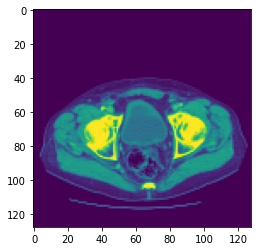

In [36]:
print(y_train[101])
plt.imshow(x_train[101])

# HOG Feature extraction:

In [37]:
# hog feature extractor
hog = cv2.HOGDescriptor()
# All feautres are appended here
x_hog = []

# loop over each image, get 2d feautures, and convert 1d(flatten)
for im in tqdm(x_train):
    # compute hog features and than flatten it
    features = hog.compute(im)
    x_hog.append(features.flatten())
    
x_hog = np.array(x_hog)
# Each image has 34020 features/image
x_hog.shape 

100%|██████████| 750/750 [00:00<00:00, 1591.85it/s]


(750, 34020)

In [38]:
print(x_hog[0])

[0. 0. 0. ... 0. 0. 0.]


# Splitting:

In [39]:
# 80% is training, 20% is testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_hog, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.2)
results = {}

In [40]:
print(x_train.shape)
print(x_test.shape)

(600, 34020)
(150, 34020)


# Applying models:

In [41]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

## SVM

In [42]:
# Train the Linear SVM
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=10000)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['SVM'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


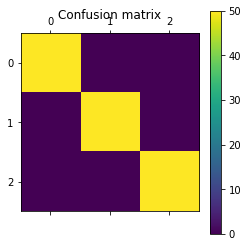

In [43]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Random Forest:

In [44]:
# creating a random forest
clf =  RandomForestClassifier(n_estimators = 100, random_state=30)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


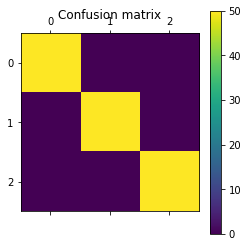

In [45]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Decision Tree:

In [46]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9933333333333333

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.98      0.99        50
           2       0.98      1.00      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



[[50  0  0]
 [ 0 49  1]
 [ 0  0 50]]


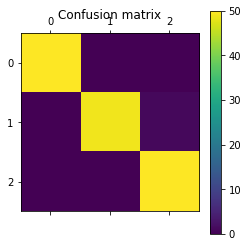

In [47]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

[Text(0.4, 0.8333333333333334, 'X[25886] <= 0.268\ngini = 0.667\nsamples = 600\nvalue = [200, 200, 200]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 200\nvalue = [200, 0, 0]'),
 Text(0.6, 0.5, 'X[18345] <= 0.323\ngini = 0.5\nsamples = 400\nvalue = [0, 200, 200]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 200\nvalue = [0, 200, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 200\nvalue = [0, 0, 200]')]

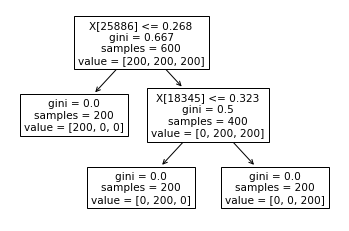

In [48]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## AdaBoost Classifier:

In [49]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['ada_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


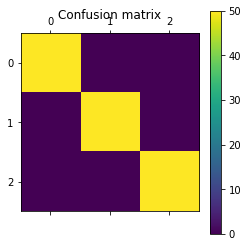

In [50]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## XG Boost Classifier:

In [51]:
# Create XG boost classifer object
xgb_clf = XGBClassifier()

xgb_clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = xgb_clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['xg_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


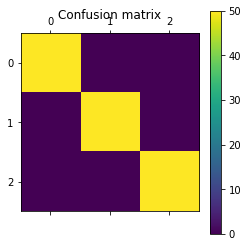

In [52]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Gaussian Naive Bayes:

In [53]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['gauss_NB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



[[50  0  0]
 [ 0 48  2]
 [ 0  0 50]]


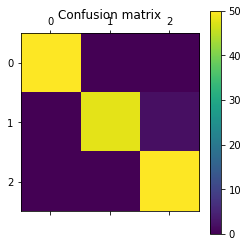

In [54]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Logistic Regression:

In [55]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['log_regression'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


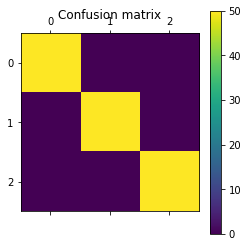

In [56]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

# Plotting the results:

<BarContainer object of 7 artists>

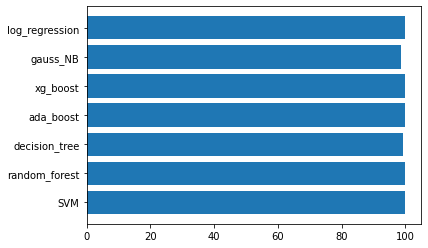

In [57]:
plt.barh(list(results.keys()), results.values())

In [58]:
results

{'SVM': 100.0,
 'ada_boost': 100.0,
 'decision_tree': 99.33,
 'gauss_NB': 98.67,
 'log_regression': 100.0,
 'random_forest': 100.0,
 'xg_boost': 100.0}